In [50]:
import pandas as pd
import seaborn as sns
import wandb
import matplotlib.pyplot as plt

# Results
Get results from Weights and Biases and produce plots for paper

In [25]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("messer/JavaDoc-Relevance-Binary-Classifier")

summary_list, config_list, name_list, group_list = [], [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    group_list.append(run.group)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "group": group_list
})

runs_df.to_csv("data/training_results.csv")
runs_df.head()

,summary,config,name,group
0,"{'_step': 6, '_timestamp': 1705953884.5296075,...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",grateful-gorge-1364,LORA:microsoft/codebert-base
1,"{'_timestamp': 1705745882.3336666, 'test/preci...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",fancy-river-1361,LORA:microsoft/codebert-base
2,"{'train/epoch': 50, 'eval/accuracy': 1, 'test/...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",golden-terrain-1356,Fine-Tuned LLM:microsoft/codebert-base
3,"{'test/accuracy': 0.8878504672897196, 'test/f1...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",laced-paper-1355,Fine-Tuned LLM:microsoft/codebert-base
4,"{'eval/accuracy': 1, 'train/train_loss': 7.181...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",fresh-violet-1354,Fine-Tuned LLM:microsoft/codebert-base


### Process WandB API call results

In [ ]:
runs_df = pd.read_csv('data/training_results.csv')

In [28]:
df = pd.concat([runs_df[['name', 'group', 'config']], pd.json_normalize(runs_df['summary'])], axis=1)

df.head()

,name,group,config,_step,_timestamp,train/global_step,eval/recall_weighted,_runtime,eval/accuracy,eval/precision_macro,...,test/runtime,test/accuracy,train/train_loss,test/recall_micro,_wandb.runtime,train/loss,train/learning_rate,test/total_time_in_seconds,test/latency_in_seconds,split
0,grateful-gorge-1364,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",6,1.705954e+09,168.0,0.44186,8574.215657,0.44186,0.408333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fancy-river-1361,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",110,1.705746e+09,120.0,0.47619,691.053951,0.47619,0.364879,...,0.8201,0.35514,1.326474e+00,0.35514,690.0,NaN,NaN,NaN,NaN,NaN
2,golden-terrain-1356,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",530,1.705627e+09,1200.0,1.00000,5151.667406,1.00000,1.000000,...,0.8195,0.88785,3.766682e-11,0.88785,5150.0,0.0,9.080286e-06,NaN,NaN,NaN
3,laced-paper-1355,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",1030,1.705621e+09,1200.0,1.00000,10120.989417,1.00000,1.000000,...,0.8206,0.88785,4.886940e-10,0.88785,10119.0,0.0,8.374323e-07,NaN,NaN,NaN
4,fresh-violet-1354,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",110,1.705611e+09,240.0,1.00000,1030.842609,1.00000,1.000000,...,0.8137,0.88785,7.181532e-10,0.88785,1029.0,NaN,NaN,NaN,NaN,NaN


### Group and produce plots

In [35]:
grouped_df = df[['group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted']].groupby('group').max().reset_index()
grouped_df.columns = ['group', 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
grouped_df

,group,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Bernolli,0.682243,0.692127,0.682243,0.680198
1,DecisionTree,0.616822,0.617826,0.616822,0.604051
2,Fine-Tuned LLM:bert-base-uncased,0.831776,0.834950,0.831776,0.829608
3,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536
4,KNeighbours,0.785047,0.796421,0.785047,0.783630
5,LORA:microsoft/codebert-base,0.355140,0.415205,0.355140,0.326727
6,LogisticRegression,0.785047,0.791682,0.785047,0.775506
7,RandomForest,0.850467,0.865247,0.850467,0.833577


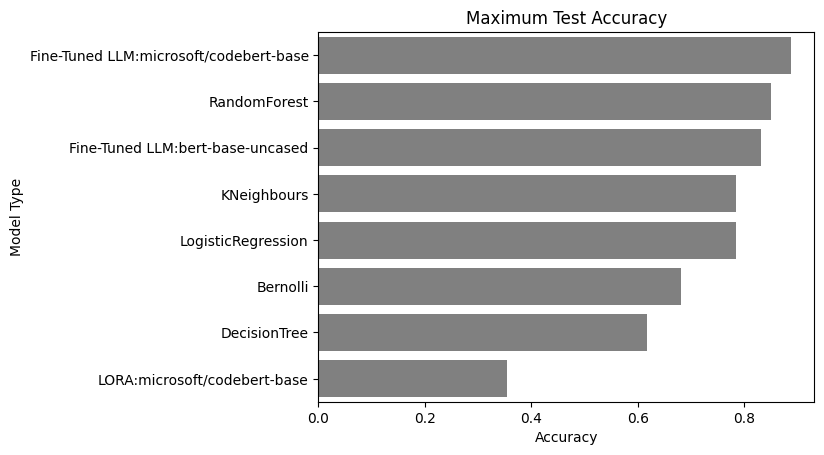

In [56]:
acc = sns.barplot(grouped_df[['group', 'accuracy']].sort_values('accuracy', ascending=False), y='group', x='accuracy', color='grey')
acc.set(title='Maximum Test Accuracy', xlabel='Accuracy', ylabel='Model Type')
acc.get_figure().savefig('plots/accuracy.pdf', bbox_inches='tight')

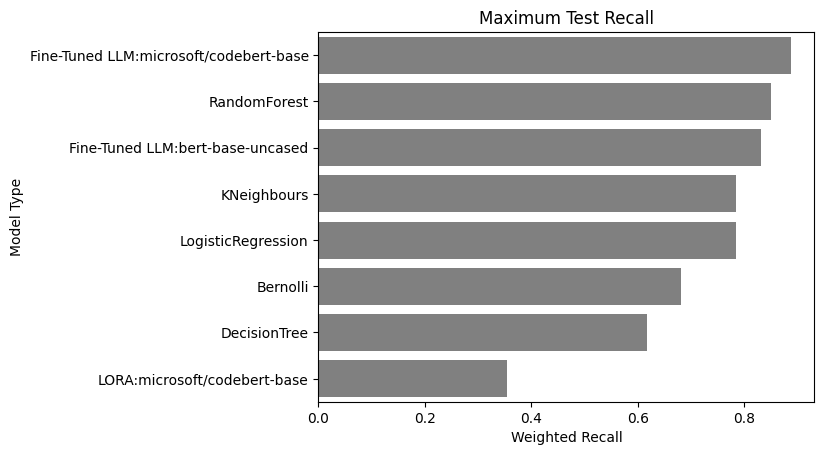

In [55]:
recall = sns.barplot(grouped_df[['group', 'recall_weighted']].sort_values('recall_weighted', ascending=False), y='group', x='recall_weighted', color='grey')
recall.set(title='Maximum Test Recall', xlabel='Weighted Recall', ylabel='Model Type')
recall.get_figure().savefig('plots/recall.pdf', bbox_inches='tight')

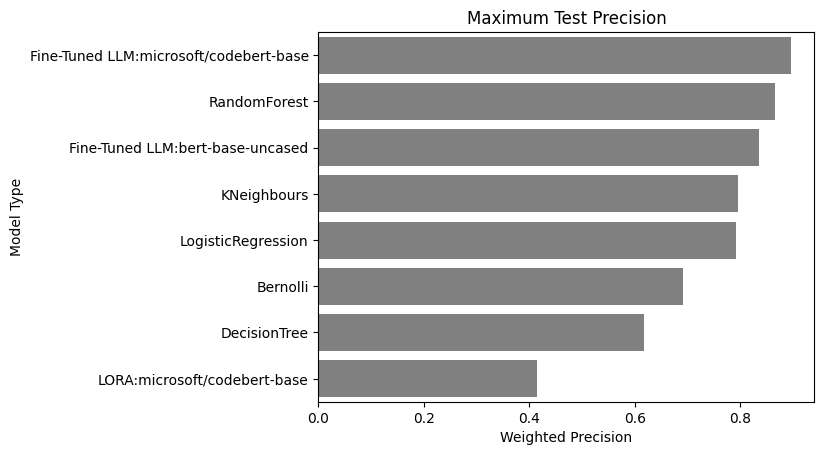

In [57]:
precision = sns.barplot(grouped_df[['group', 'precision_weighted']].sort_values('precision_weighted', ascending=False), y='group', x='precision_weighted', color='grey')
precision.set(title='Maximum Test Precision', xlabel='Weighted Precision', ylabel='Model Type')
precision.get_figure().savefig('plots/precision.pdf', bbox_inches='tight')

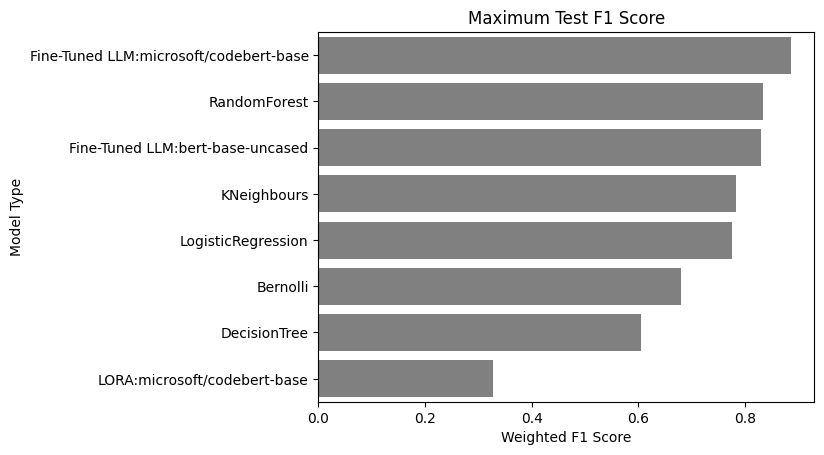

In [58]:
f1 = sns.barplot(grouped_df[['group', 'f1_weighted']].sort_values('f1_weighted', ascending=False), y='group', x='f1_weighted', color='grey')
f1.set(title='Maximum Test F1 Score', xlabel='Weighted F1 Score', ylabel='Model Type')
f1.get_figure().savefig('plots/f1.pdf', bbox_inches='tight')